In [1]:
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, Aer
from qiskit import transpile, assemble
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np
from qiskit.extensions import XGate

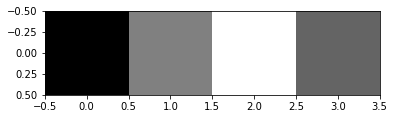

In [2]:
image = np.array([0, 128, 255, 100]).reshape(1,4)
plt.imshow(image, cmap = 'gray')
plt.show()

In [3]:
x = 1
y = 2
q = 8

color = QuantumRegister(q, 'color')
y_ax = QuantumRegister(y, 'y axis')
x_ax = QuantumRegister(x, 'x axis')
classic = ClassicalRegister(x+y+q, 'classic')
qc = QuantumCircuit(color, y_ax, x_ax, classic)

qc.i(color)
qc.h(x_ax)
qc.h(y_ax)
qc.barrier()

#first pixel
qc.i(range(0,qc.num_qubits))
qc.barrier()

#second pixel
qc.x(y_ax)
controls = [x_ax[0], y_ax[1], y_ax[0]]
xg = XGate(None).control(len(controls))
controls.append(0)
qc.append(xg, controls)
qc.x(y_ax)
qc.barrier()

#third pixel
qc.x(x_ax)
qc.x(y_ax[0])
for i in reversed(list(range(color.size))):
    controls = [x_ax[0], y_ax[1], y_ax[0]]
    xg = XGate(None).control(len(controls))
    controls.append(i)
    qc.append(xg, controls)
qc.x(x_ax)
qc.x(y_ax[0])
qc.barrier()

#fourth pixel
qc.x(y_ax[0])
for i in reversed([1,2,5]):
    controls = [x_ax[0], y_ax[1], y_ax[0]]
    xg = XGate(None).control(len(controls))
    controls.append(i)
    qc.append(xg, controls)
qc.x(y_ax[0])
qc.barrier()

#measure
qc.measure(list(reversed(range(qc.num_qubits))), range(classic.size))

qc.draw()

<pre style="word-wrap: normal;white-space: pre;background: #fff0;line-height: 1.1;font-family: &quot;Courier New&quot;,Courier,monospace">            ┌───┐ ░ ┌───┐ ░      ┌───┐      ░                               »
   color_0: ┤ I ├─░─┤ I ├─░──────┤ X ├──────░───────────────────────────────»
            ├───┤ ░ ├───┤ ░      └─┬─┘      ░                               »
   color_1: ┤ I ├─░─┤ I ├─░────────┼────────░───────────────────────────────»
            ├───┤ ░ ├───┤ ░        │        ░                               »
   color_2: ┤ I ├─░─┤ I ├─░────────┼────────░───────────────────────────────»
            ├───┤ ░ ├───┤ ░        │        ░                          ┌───┐»
   color_3: ┤ I ├─░─┤ I ├─░────────┼────────░──────────────────────────┤ X ├»
            ├───┤ ░ ├───┤ ░        │        ░                     ┌───┐└─┬─┘»
   color_4: ┤ I ├─░─┤ I ├─░────────┼────────░─────────────────────┤ X ├──┼──»
            ├───┤ ░ ├───┤ ░        │        ░                ┌───┐└─┬─┘  │  »
   color_5: ┤ I ├─░─┤ I ├─░────────┼────────░────────────────┤ X ├──┼────┼──»
            ├───┤ ░ ├───┤ ░        │        ░           ┌───┐└─┬─┘  │    │  »
   color_6: ┤ I ├─░─┤ I ├─░────────┼────────░───────────┤ X ├──┼────┼────┼──»
            ├───┤ ░ ├───┤ ░        │        ░      ┌───┐└─┬─┘  │    │    │  »
   color_7: ┤ I ├─░─┤ I ├─░────────┼────────░──────┤ X ├──┼────┼────┼────┼──»
            ├───┤ ░ ├───┤ ░ ┌───┐  │  ┌───┐ ░ ┌───┐└─┬─┘  │    │    │    │  »
  y axis_0: ┤ H ├─░─┤ I ├─░─┤ X ├──■──┤ X ├─░─┤ X ├──■────■────■────■────■──»
            ├───┤ ░ ├───┤ ░ ├───┤  │  ├───┤ ░ └───┘  │    │    │    │    │  »
  y axis_1: ┤ H ├─░─┤ I ├─░─┤ X ├──■──┤ X ├─░────────■────■────■────■────■──»
            ├───┤ ░ ├───┤ ░ └───┘  │  └───┘ ░ ┌───┐  │    │    │    │    │  »
  x axis_0: ┤ H ├─░─┤ I ├─░────────■────────░─┤ X ├──■────■────■────■────■──»
            └───┘ ░ └───┘ ░                 ░ └───┘                         »
classic: 11/════════════════════════════════════════════════════════════════»
                                                                            »
«                      ┌───┐      ░                           ░                »
«   color_0: ──────────┤ X ├──────░───────────────────────────░────────────────»
«                 ┌───┐└─┬─┘      ░                ┌───┐      ░                »
«   color_1: ─────┤ X ├──┼────────░────────────────┤ X ├──────░────────────────»
«            ┌───┐└─┬─┘  │        ░           ┌───┐└─┬─┘      ░                »
«   color_2: ┤ X ├──┼────┼────────░───────────┤ X ├──┼────────░────────────────»
«            └─┬─┘  │    │        ░           └─┬─┘  │        ░                »
«   color_3: ──┼────┼────┼────────░─────────────┼────┼────────░────────────────»
«              │    │    │        ░             │    │        ░                »
«   color_4: ──┼────┼────┼────────░─────────────┼────┼────────░────────────────»
«              │    │    │        ░      ┌───┐  │    │        ░                »
«   color_5: ──┼────┼────┼────────░──────┤ X ├──┼────┼────────░────────────────»
«              │    │    │        ░      └─┬─┘  │    │        ░             ┌─┐»
«   color_6: ──┼────┼────┼────────░────────┼────┼────┼────────░─────────────┤M├»
«              │    │    │        ░        │    │    │        ░          ┌─┐└╥┘»
«   color_7: ──┼────┼────┼────────░────────┼────┼────┼────────░──────────┤M├─╫─»
«              │    │    │  ┌───┐ ░ ┌───┐  │    │    │  ┌───┐ ░       ┌─┐└╥┘ ║ »
«  y axis_0: ──■────■────■──┤ X ├─░─┤ X ├──■────■────■──┤ X ├─░───────┤M├─╫──╫─»
«              │    │    │  └───┘ ░ └───┘  │    │    │  └───┘ ░    ┌─┐└╥┘ ║  ║ »
«  y axis_1: ──■────■────■────────░────────■────■────■────────░────┤M├─╫──╫──╫─»
«              │    │    │  ┌───┐ ░        │    │    │        ░ ┌─┐└╥┘ ║  ║  ║ »
«  x axis_0: ──■────■────■──┤ X ├─░────────■────■────■────────░─┤M├─╫──╫──╫──╫─»
«                           └───┘ ░                           ░ └╥┘ ║  ║  ║  ║ »
«classic: 11/════════════════════════════════════

In [5]:
aer_sim = Aer.get_backend('aer_simulator')
t_qc_image = transpile(qc, aer_sim)
qobj = assemble(t_qc_image, shots=10000)
job_neqr = aer_sim.run(qobj)
result_neqr = job_neqr.result()
counts_neqr = result_neqr.get_counts()
# plot_histogram(counts_neqr)
# plt.show()

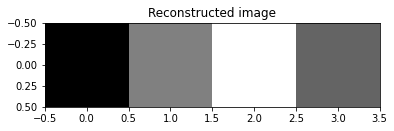

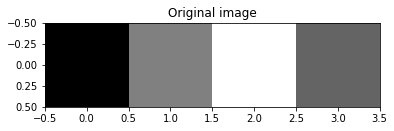

In [6]:
out_pixels = []
for item in counts_neqr:
    out_pixels.append((int(item[0:color.size], 2), int(item[color.size:],2)))
out_image = np.zeros((len(image.flatten(),)))
for pixel in out_pixels:
    if pixel[1]<out_image.shape[0]:
        out_image[pixel[1]] = pixel[0]
out_image = np.reshape(out_image, (image.shape))
plt.imshow(out_image, cmap = 'gray')
plt.title('Reconstructed image')
plt.show()
plt.imshow(image, cmap = 'gray')
plt.title('Original image')
plt.show()

In [7]:
print(qc.depth())

21


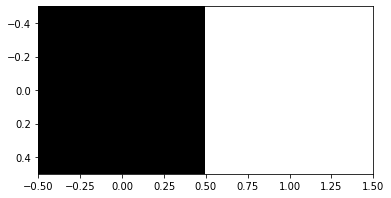

In [8]:
image = np.array([0,1]).reshape(1,2)
color_bit_range = 1
plt.imshow(image, cmap = 'gray')
plt.show()

In [9]:
x = 1
y = 1
q = 1

color = QuantumRegister(q, 'color')
y_ax = QuantumRegister(y, 'y axis')
x_ax = QuantumRegister(x, 'x axis')
classic = ClassicalRegister(x+y+q, 'classic')
qc = QuantumCircuit(color, y_ax, x_ax, classic)

qc.i(color)
qc.h(x_ax)
qc.h(y_ax)
qc.barrier()

#first pixel
qc.i(range(0,qc.num_qubits))
qc.barrier()

#second pixel
qc.x(y_ax)
qc.ccx(x_ax[0], y_ax[0], color[0])
qc.x(y_ax)
qc.barrier()

#measure
qc.measure(list(reversed(range(qc.num_qubits))), range(classic.size))

qc.draw()

<pre style="word-wrap: normal;white-space: pre;background: #fff0;line-height: 1.1;font-family: &quot;Courier New&quot;,Courier,monospace">           ┌───┐ ░ ┌───┐ ░      ┌───┐      ░       ┌─┐
  color_0: ┤ I ├─░─┤ I ├─░──────┤ X ├──────░───────┤M├
           ├───┤ ░ ├───┤ ░ ┌───┐└─┬─┘┌───┐ ░    ┌─┐└╥┘
 y axis_0: ┤ H ├─░─┤ I ├─░─┤ X ├──■──┤ X ├─░────┤M├─╫─
           ├───┤ ░ ├───┤ ░ └───┘  │  └───┘ ░ ┌─┐└╥┘ ║ 
 x axis_0: ┤ H ├─░─┤ I ├─░────────■────────░─┤M├─╫──╫─
           └───┘ ░ └───┘ ░                 ░ └╥┘ ║  ║ 
classic: 3/═══════════════════════════════════╩══╩══╩═
                                              0  1  2 </pre>

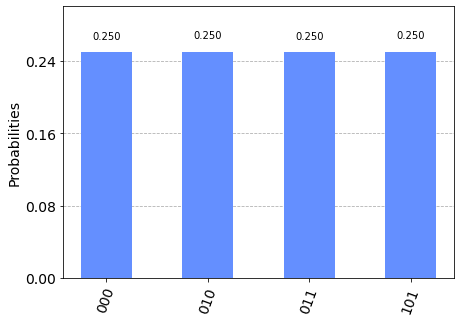

In [10]:
aer_sim = Aer.get_backend('aer_simulator')
t_qc_image = transpile(qc, aer_sim)
qobj = assemble(t_qc_image, shots=1000000)
job_neqr = aer_sim.run(qobj)
result_neqr = job_neqr.result()
counts_neqr = result_neqr.get_counts()
plot_histogram(counts_neqr)
plt.show()

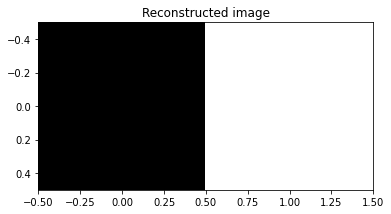

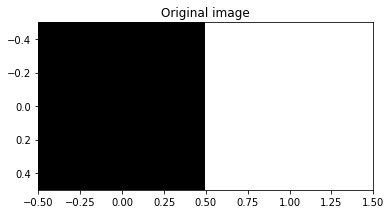

In [10]:
out_pixels = []
for item in counts_neqr:
    out_pixels.append((int(item[0:color.size], 2), int(item[color.size:],2)))
out_image = np.zeros((len(image.flatten(),)))
for pixel in out_pixels:
    if pixel[1]<out_image.shape[0]:
        out_image[pixel[1]] = pixel[0]
out_image = np.reshape(out_image, (image.shape))
plt.imshow(out_image, cmap = 'gray')
plt.title('Reconstructed image')
plt.show()
plt.imshow(image, cmap = 'gray')
plt.title('Original image')
plt.show()